# National Land Cover Database (NLCD)

### Overview
Land cover data helps characterize surface properties, which influence runoff, infiltration, and evapotranspiration.

**Source:** [<u>Link to data</u>](https://www.mrlc.gov/data?f%5B0%5D=category%3ALand%20Cover&f%5B1%5D=project_tax_term_term_parents_tax_term_name%3AAnnual%20NLCD&f%5B2%5D=year%3A2001&f%5B3%5D=year%3A2006&f%5B4%5D=year%3A2011&f%5B5%5D=year%3A2016&f%5B6%5D=year%3A2019&f%5B7%5D=year%3A2020&f%5B8%5D=year%3A2021&f%5B9%5D=year%3A2022&f%5B10%5D=year%3A2023)

**Notebook Author:** Cassie Buhler

### Streaming data
To avoid downloading large files directly to our computers, we can stream the data using its URL. Sometimes the URL is easily accessible, but if it's not, here's how to find the download link using Google Chrome:

1. Start downloading the file from the website as usual.
2. Once the download starts, go to the Chrome Downloads page:
    - Either press Ctrl + J (Windows/Linux) or Cmd + Shift + J (Mac)
    - or click the three-dot menu > Downloads.
3. Find the file you're downloading in the list and right-click on the download entry
   - Click "Copy link address" or click the link emoticon


In [1]:
# urls to NLCD for select years
yr2001_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2001_CU_C1V0.tif'
yr2006_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2006_CU_C1V0.tif'
yr2011_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2011_CU_C1V0.tif'
yr2016_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2016_CU_C1V0.tif'
yr2019_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2019_CU_C1V0.tif'
yr2020_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2020_CU_C1V0.tif'
yr2021_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2021_CU_C1V0.tif'
yr2022_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2022_CU_C1V0.tif'
yr2023_url = 'https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2023_CU_C1V0.tif'

## Inspect spatial projection and extent
Let's check the **coordination reference system (CRS)** of the data to see what projection is being used. It's also good to check the **spatial extent**, as it tells us the area our data covers. 

Typically, a CRS is associated with a standard **EPSG code** (e.g., EPSG:4326 for WGS 84), which makes it easy to reference. However, in our case, these rasters use a **custom Albers Equal Area projection**, so instead of a simple EPSG code, it returns the full projection definition string (in WKT format).

In [2]:
import rioxarray as rxr
import rasterio
# prevents GDAL from reading extra TIFF directories 
# if you remove the "with" statement, it'll print out noisy (but harmless) errors
with rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='TRUE'):
    yr2001 = rxr.open_rasterio(yr2001_url, masked=True)
    yr2006 = rxr.open_rasterio(yr2006_url, masked=True)
    yr2011 = rxr.open_rasterio(yr2011_url, masked=True)
    yr2016 = rxr.open_rasterio(yr2016_url, masked=True)
    yr2019 = rxr.open_rasterio(yr2019_url, masked=True)
    yr2020 = rxr.open_rasterio(yr2020_url, masked=True)
    yr2021 = rxr.open_rasterio(yr2021_url, masked=True)
    yr2022 = rxr.open_rasterio(yr2022_url, masked=True)
    yr2023 = rxr.open_rasterio(yr2023_url, masked=True)

# check the CRS and spatial extent
print("The CRS:", yr2001.rio.crs)
print("Spatial extent:", yr2001.rio.bounds())

The CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Spatial extent: (-2415585.0, 164805.0, 2384415.0, 3314805.0)


## Crop and reproject data

In this example, the data is currently in a **custom Albers Equal Area projection**, which represents spatial locations in meters. This is a projected CRS, optimized for area preservation.

In our data cube, we will use `EPSG:32613` (which corresponds to UTM Zone 13N), a projection in meters that fully encompasses the **Black Hills**.

The spatial extent of the current dataset (in projected meters) is:
- Northing (Y): -2415585 m to 2384415.0 m
- Easting (X): 164805 m to 3314805.0 m

This bounding box covers a sizeable chunk of North America, but we are only interested in the Black Hills. To focus on this specific area, we will crop the data to a smaller bounding box and reproject the data to `EPSG:32613`.

The Black Hills bounding box in UTM 13:
- Top: 4961634.142366057 m (`ymax`)
- Bottom: 4791372.654461951 m (`ymin`)
- Left: 522738.38883301965 m (`xmin`)
- Right: 634142.3594250776 m (`xmax`)



In [3]:
# a function to clip and reproject our data
def crop_and_reproject(data, crs = 'EPSG:32613'):
    # black hills bounding box 
    ymax = 4961634.142366057
    ymin = 4791372.654461951
    xmin = 522738.38883301965
    xmax = 634142.3594250776

    # crop data to Black Hills 
    data = data.rio.clip_box(
        minx=xmin,
        miny=ymin,
        maxx=xmax,
        maxy=ymax,
    crs=crs)

    # reproject data to EPSG:32613 
    data = data.rio.reproject(crs)
    return data 

In [4]:
# call the function on each raster
yr2001 = crop_and_reproject(yr2001)
yr2006 = crop_and_reproject(yr2006)
yr2011 = crop_and_reproject(yr2011)
yr2016 = crop_and_reproject(yr2016)
yr2019 = crop_and_reproject(yr2019)
yr2020 = crop_and_reproject(yr2020)
yr2021 = crop_and_reproject(yr2021)
yr2022 = crop_and_reproject(yr2022)
yr2023 = crop_and_reproject(yr2023)

## Data structure 
All raster files have X, Y, and band values.

- X and Y give the pixel’s location
- A band holds the data value for that location.

A single-band raster might show brightness or elevation. Multi-band rasters store different types of data in each band (e.g. red light, infrared, or temperature) allowing deeper analysis. 

Let's print out the **shape** of the NLCD 2001 raster, where shape = (bands, X, Y).

In [5]:
# 1 band, 105000 pixels wide, 160000 pixels tall 
print("yr2001 shape:", yr2001.shape) 

yr2001 shape: (1, 6389, 4812)


## Examine data values
For NLCD, the files are single-banded, where each pixel’s value represents its **land cover class**.

**Land cover classifications**: <u>https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description</u>

To see what types of land cover exist in the Black Hills in 2001, we check the **unique values** in the raster. Looking at these values and their **frequencies** shows which land cover types are present and which are most common. A bar chart gives a quick visual summary of the landscape. 

We see that most pixels are `71` and `42` which are `Grassland/Herbaceous` and `Evergreen Forest`, respectively. 

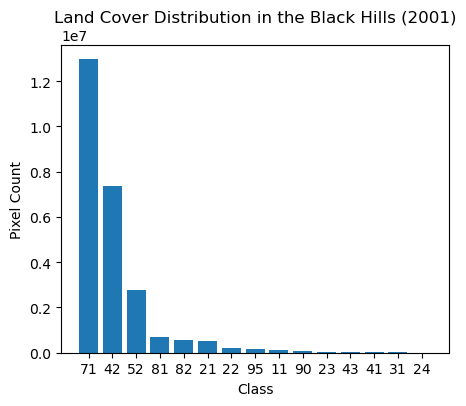

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# extracts the land cover classes and how many times each of them show up in the raster 
# also filtering out missing data (NA values)
values, counts = np.unique(yr2001.values[~np.isnan(yr2001.values)], return_counts=True)

# sort in descending order (most common to least)
sorted_idx = np.argsort(-counts) 
values_sorted = values[sorted_idx].astype(int) # cast to int to get rid of decimal in xlabel 
counts_sorted = counts[sorted_idx]

# create a histogram 
fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(values_sorted.astype(str), counts_sorted) 
ax.set_xlabel('Class')
ax.set_ylabel('Pixel Count')
ax.set_title('Land Cover Distribution in the Black Hills (2001)')

plt.show() #display figure 

## Visualize data
Now that we’ve processed our data and understand its structure, let’s create some visualizations!

There are multiple ways to visualize NLCD data, and other tutorials may use different packages. In this example, we will use `pygeohydro`, a package with plotting utilities tailored for NLCD data, which ensures that our maps use the correct colors and are consistent with other NLCD visualizations.

If you don’t have the package already installed, **uncomment the code** below to **install it** using **pip**.

In [7]:
# %pip install pygeohydro

#### Plot NLCD for each year, side by side

Plotting multiple years of NLCD data side by side allows us to visually compare how land cover has changed over time in the Black Hills. 

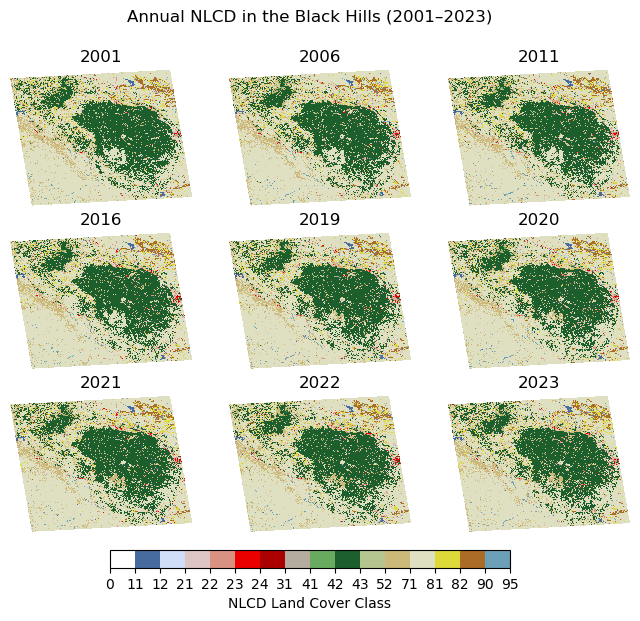

In [8]:
import pygeohydro as gh # package to help us plot nlcd 

# grid of 3x3 subplots (9 total) 
fig, axs = plt.subplots(3, 3, figsize=(8, 6), sharex=True, sharey=True)
fig.suptitle('Annual NLCD in the Black Hills (2001–2023)') # main title 

years =[2001,2006,2011,2016,2019,2020,2021,2022,2023] # titles for each subplot 
datasets = [yr2001,yr2006,yr2011,yr2016,yr2019,yr2020,yr2021,yr2022,yr2023] #rasters for each subplot 

# USGS color schemes for land cover classes 
cmap, norm, levels = gh.plot.cover_legends()

# loop through each raster and plot each one 
for ax,year,data in zip(axs.flatten(),years, datasets):
    ax.axis('off') #turning off x/y labels 
    data.plot(ax=ax, cmap=cmap, levels=levels, add_colorbar=False) #plot a raster 
    ax.set_title(str(year)) 

# add a legend below all subplots
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # [left, bottom, width, height] in figure coords
fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='horizontal',
    ticks=levels[:-1],
    label='NLCD Land Cover Class'
)

plt.show() 

## Land cover transitions between 2001 and 2023.
Another way to see how a landscape has changed over time is to use a **transition matrix**. This shows how many pixels switched from one land cover type to another between 2001 and 2023. 

In a transition matrix, each **row represents the land cover type in 2001**, and each **column represents the land cover type in 2023**. The color in the table shows how many pixels moved from the row’s class to the column’s class. Darker blue means more pixels changed between those two classes.

In our data, the largest land cover changes between 2001 and 2023 were from `Shrub/Scrub` (52) to `Evergreen Forest` (42) and from `Evergreen Forest` (42) to `Grassland/Herbaceous` (71).

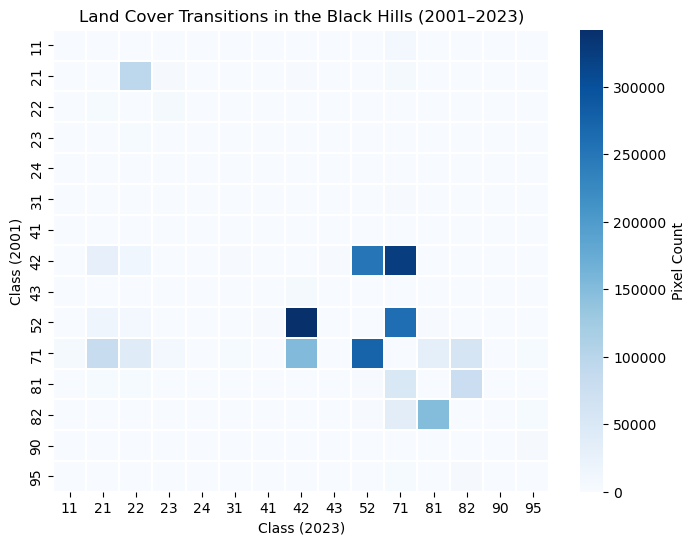

In [9]:
import pandas as pd
import seaborn as sns

# flatten arrays 
s = yr2001.values.flatten()
e = yr2023.values.flatten()

# only look at pairs that aren't missing data
mask = ~np.isnan(s) & ~np.isnan(e)
s_clean = s[mask].astype(int)
e_clean = e[mask].astype(int)

# create transition matrix 
transition_matrix = pd.crosstab(s_clean, e_clean)

# remove unchanged transitions by zeroing the diagonal
np.fill_diagonal(transition_matrix.values, 0)

# plot transition matrix as heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    transition_matrix, 
    cmap='Blues', # color palette, darker blue -> more pixels 
    linewidths=0.1, # thin grid lines
    cbar_kws={'label': 'Pixel Count'}  # colorbar label
)

plt.xlabel('Class (2023)')
plt.ylabel('Class (2001)')
plt.title('Land Cover Transitions in the Black Hills (2001–2023)')
plt.show()